In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)

# Load data and preprocessing
def load_data():
    df = pd.read_csv("creditcard.csv")
    df = df.drop(['Time', 'Amount'], axis=1)
    features = df.drop('Class', axis=1)
    labels = df['Class']

    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data()
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

#data
print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)
print("Train labels shape: ", y_train.shape)
print("Test labels shape: ", y_test.shape)
print("Train labels distribution: ", y_train.value_counts())
print("Test labels distribution: ", y_test.value_counts())


Train data shape:  (227845, 28)
Test data shape:  (56962, 28)
Train labels shape:  (227845,)
Test labels shape:  (56962,)
Train labels distribution:  Class
0    227451
1       394
Name: count, dtype: int64
Test labels distribution:  Class
0    56864
1       98
Name: count, dtype: int64


In [17]:
df = pd.read_csv("creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [10]:
# Define models
class TransformerAutoencoder(pl.LightningModule):
    def __init__(self, feature_dim=28, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(feature_dim, latent_dim), nn.ReLU(), nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=latent_dim, nhead=4), num_layers=2))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, feature_dim), nn.Sigmoid())

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

class Generator(nn.Module):
    def __init__(self, latent_dim=16, output_dim=28):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(latent_dim, 32), nn.ReLU(), nn.Linear(32, output_dim), nn.Tanh())

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim=28):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(input_dim, 32), nn.LeakyReLU(0.1), nn.Linear(32, 1), nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class GAN(pl.LightningModule):
    def __init__(self, generator, discriminator, latent_dim=16):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.automatic_optimization = False

    def adversarial_loss(self, y_hat, y):
        return nn.functional.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        batch_size = real_imgs.shape[0]
        opt_gen, opt_disc = self.optimizers()

        # Train generator
        z = torch.randn(batch_size, self.latent_dim, device=self.device)
        generated_imgs = self.generator(z)
        valid = torch.ones(batch_size, 1, device=self.device)
        g_loss = self.adversarial_loss(self.discriminator(generated_imgs), valid)

        opt_gen.zero_grad()
        self.manual_backward(g_loss)
        opt_gen.step()

        # Train discriminator
        real_loss = self.adversarial_loss(self.discriminator(real_imgs), valid)
        fake = torch.zeros(batch_size, 1, device=self.device)
        fake_loss = self.adversarial_loss(self.discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        opt_disc.zero_grad()
        self.manual_backward(d_loss)
        opt_disc.step()

    def configure_optimizers(self):
        lr = 2e-4
        b1 = 0.5
        b2 = 0.999
        optimizer_gen = optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        optimizer_disc = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return optimizer_gen, optimizer_disc

    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=128, shuffle=True)



In [ ]:
generator = Generator(latent_dim=16, output_dim=28)
discriminator = Discriminator(input_dim=28)
gan_model = GAN(generator, discriminator)

checkpoint_callback = ModelCheckpoint(
    monitor='g_loss',
    dirpath='./',
    filename='gan-{epoch:02d}-{g_loss:.2f}',
    save_top_k=1
)

trainer = pl.Trainer(
    max_epochs=50, 
    accelerator='gpu' if torch.cuda.is_available() else None, 
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[checkpoint_callback]
)

trainer.fit(gan_model)


In [5]:
#save the model
torch.save(gan_model.state_dict(), 'gan_model.pth')


In [11]:
# Load the saved model
loaded_gan_model = GAN(generator=Generator(latent_dim=16, output_dim=28), discriminator=Discriminator(input_dim=28))
loaded_gan_model.load_state_dict(torch.load("gan_model.pth"))

# Make sure to put the loaded model in evaluation mode if you want to use it for inference
loaded_gan_model.eval()

GAN(
  (generator): Generator(
    (model): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=28, bias=True)
      (3): Tanh()
    )
  )
  (discriminator): Discriminator(
    (model): Sequential(
      (0): Linear(in_features=28, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
)

              precision    recall  f1-score   support

        Fake       0.96      1.00      0.98    227845
        Real       1.00      0.96      0.98    227845

    accuracy                           0.98    455690
   macro avg       0.98      0.98      0.98    455690
weighted avg       0.98      0.98      0.98    455690



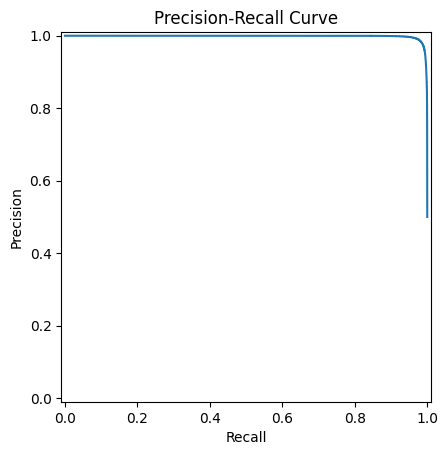

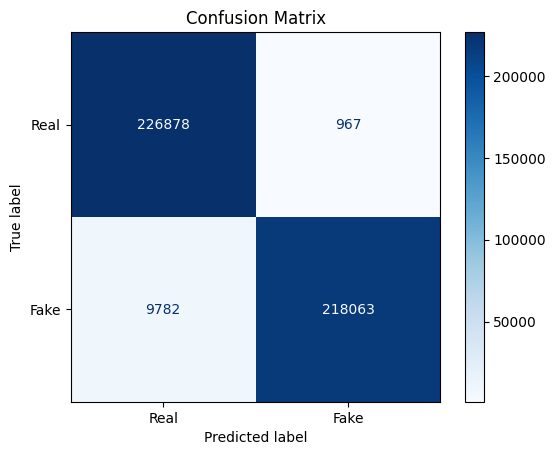

In [3]:
# Evaluate Discriminator
def evaluate_discriminator(discriminator, data_loader, device):
    discriminator.eval()
    y_pred = []
    y_true = []
    y_scores = []

    with torch.no_grad():
        for imgs, _ in data_loader:
            imgs = imgs.to(device)
            real_scores = discriminator(imgs)
            y_scores.extend(real_scores.squeeze().cpu().numpy())
            y_pred.extend((real_scores > 0.5).int().squeeze().cpu().numpy())
            y_true.extend(torch.ones(imgs.size(0)).cpu().numpy())

            z = torch.randn(imgs.size(0), 16, device=device)
            fake_imgs = gan_model.generator(z)
            fake_scores = discriminator(fake_imgs)
            y_scores.extend(fake_scores.squeeze().cpu().numpy())
            y_pred.extend((fake_scores > 0.5).int().squeeze().cpu().numpy())
            y_true.extend(torch.zeros(fake_imgs.size(0)).cpu().numpy())

    # Display Classification Report
    print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title('Precision-Recall Curve')
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp_cm.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
evaluate_discriminator(gan_model.discriminator, train_loader, device)